# Подбор параметров (руками)

In [435]:
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import time
import numpy as np
from typing import Callable
import random
import math
import matplotlib.pyplot as plt

from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.de import DE

import nevergrad as ng

import cma

from continuous_ga_core.clusterization import *
from continuous_ga_core.crossover import *
from continuous_ga_core.evaluation import *
from continuous_ga_core.crossover import *
from continuous_ga_core.evaluation import *
from continuous_ga_core.interaction import *
from continuous_ga_core.logger import *
from continuous_ga_core.mutation import *
from continuous_ga_core.pipeline import *
from continuous_ga_core.population import *
from continuous_ga_core.selection import *
from continuous_ga_core.termination import *
from continuous_ga_core.visualization import *
from utils.visualization import show_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Библиотечные функции оптимизации

In [2]:
def run_with_time_limit(
        f: Callable[[np.ndarray], float],
        optimizer_step,
        time_limit: float
):
    """
    Универсальный тайм-лимитер для оптимизаторов без встроенного time_budget.
    """
    start = time.time()
    best_x, best_f = None, float("inf")

    while time.time() - start < time_limit:
        x = optimizer_step()
        fx = f(x)
        if fx < best_f:
            best_x, best_f = x, fx

    return best_x, best_f


def optimize_pymoo(
        f: Callable[[np.ndarray], float],
        dimension: int,
        bounds: tuple,
        time_limit: float = None,
        eval_budget: int = None,
        seed: int = 1
):
    class Problem(ElementwiseProblem):
        def __init__(self):
            super().__init__(
                n_var=dimension,
                n_obj=1,
                xl=bounds[0],
                xu=bounds[1]
            )

        def _evaluate(self, x, out, *args, **kwargs):
            out["F"] = f(x)

    algorithm = DE(pop_size=10 * dimension)

    termination = None
    if time_limit is not None:
        termination = ("time", time_limit)
    elif eval_budget is not None:
        termination = ("n_eval", eval_budget)

    res = minimize(
        Problem(),
        algorithm,
        termination=termination,
        seed=seed,
        verbose=False
    )

    return res.X, res.F[0]


def optimize_nevergrad(
        f: Callable[[np.ndarray], float],
        dimension: int,
        bounds: tuple,
        budget: int,
        optimizer_name: str = "NGOpt",
        num_workers: int = 1
):
    parametrization = ng.p.Array(
        shape=(dimension,)
    ).set_bounds(bounds[0], bounds[1])

    optimizer_cls = getattr(ng.optimizers, optimizer_name)

    optimizer = optimizer_cls(
        parametrization=parametrization,
        budget=budget,
        num_workers=num_workers
    )

    recommendation = optimizer.minimize(f)

    return recommendation.value, recommendation.loss


def optimize_pycma(
        f: Callable[[np.ndarray], float],
        dimension: int,
        bounds: tuple,
        eval_budget: int,
        sigma: float = 100.0,
        seed: int = 1
):
    x0 = np.zeros(dimension)

    es = cma.CMAEvolutionStrategy(
        x0,
        sigma,
        {
            "bounds": [bounds[0], bounds[1]],
            "maxfevals": eval_budget,
            "seed": seed,
            "verbose": -9
        }
    )

    es.optimize(f)

    x_best = es.result.xbest
    f_best = es.result.fbest

    return x_best, f_best


class LoggedProblem(ElementwiseProblem):
    def __init__(self, f, n, bounds, history):
        super().__init__(n_var=n, n_obj=1, xl=bounds[0], xu=bounds[1])
        self.f = f
        self.history = history
        self.best = float("inf")

    def _evaluate(self, x, out, *args, **kwargs):
        fx = self.f(x)
        self.best = min(self.best, fx)
        self.history.append(self.best)
        out["F"] = fx


def run_pymoo_with_history(f, n, bounds, eval_budget):
    history = []

    problem = LoggedProblem(f, n, bounds, history)

    minimize(
        problem,
        DE(pop_size=10 * n),
        termination=("n_eval", eval_budget),
        verbose=False
    )

    return history, history[-1]


def run_nevergrad_with_history(f, n, bounds, budget):
    parametrization = ng.p.Array(shape=(n,)).set_bounds(bounds[0], bounds[1])
    optimizer = ng.optimizers.NGOpt(parametrization=parametrization, budget=budget)

    best = float("inf")
    history = []

    for _ in range(budget):
        x = optimizer.ask()
        fx = float(f(x.value))
        optimizer.tell(x, fx)

        best = min(best, fx)
        history.append(max(best, 1e-12))  # защита для log-scale

    return history, history[-1]


def run_pycma_with_history(f, n, bounds, eval_budget, sigma=100.0):
    history = []

    def callback(es):
        history.extend(
            [es.result.fbest] * es.popsize
        )

    es = cma.CMAEvolutionStrategy(
        np.zeros(n),
        sigma,
        {
            "bounds": [bounds[0], bounds[1]],
            "maxfevals": eval_budget,
            "verbose": -9
        }
    )

    es.optimize(f, callback=callback)

    return history[:eval_budget], history[:eval_budget][-1]


def plot_convergence(histories, labels, title):
    plt.figure()
    for hist, label in zip(histories, labels):
        plt.plot(hist, label=label)

    plt.yscale("log")
    plt.xlabel("Iteration / Evaluation")
    plt.ylabel("Best f(x) so far")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## Генетические алгоритмы

In [486]:
ga = GeneticAlgorithm(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.02)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.8,
        crossover_fn=blend_crossover,
        alpha=0.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=gaussian_mutation,
        sigma=0.5
    ),
    termination_fn=termination_by_generation
)

gas_hdb_griewangks = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.05)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.0,
        crossover_fn=adaptive_blend_crossover_diversity,
        alpha_min=0.4,
        alpha_max=2.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=adaptive_gaussian_mutation_diversity,
        sigma_min=0.6,
        sigma_max=2.5
    ),
    clusterization_fn=lambda pop: hdbscan_clusterization_indices(
        population=pop,
        min_cluster_size=10
    ),
    role_assignment_fn=lambda sp: assign_roles_median(
        species=sp
    ),
    interaction_fn=lambda pop, fit, sp: predator_prey_interaction(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=0.4,
        gamma=0.8,
        sigma=100
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

gas_db_griewangks = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.02)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=0.9,
        crossover_fn=adaptive_blend_crossover_diversity,
        alpha_min=0.4,
        alpha_max=2.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=adaptive_gaussian_mutation_diversity,
        sigma_min=0.6,
        sigma_max=2.5
    ),
    clusterization_fn=lambda pop: dbscan_clusterization_indices(
        population=pop,
        eps=0.4,
        min_samples=5
    ),
    role_assignment_fn=lambda sp: assign_roles_median(
        species=sp
    ),
    interaction_fn=lambda pop, fit, sp: predator_prey_interaction(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=0.4,
        gamma=0.8,
        sigma=120
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

gas_hdb_best_s = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.02)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=0.6,
        crossover_fn=adaptive_blend_crossover_diversity,
        alpha_min=0.4,
        alpha_max=2.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=0.6,
        mutation_fn=adaptive_gaussian_mutation_diversity,
        sigma_min=0.6,
        sigma_max=2.5
    ),
    clusterization_fn=lambda pop: hdbscan_clusterization_indices(
        population=pop,
        min_cluster_size=11
    ),
    role_assignment_fn=lambda sp: assign_roles_median_stochastic(
        species=sp,
        alpha=4.2
    ),
    interaction_fn=lambda pop, fit,
                          sp: predator_prey_interaction_with_mean_fitness_update_with_solve_and_scale(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=0.4,
        gamma=0.8,
        sigma=4.0
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

gas_hdb_best_1 = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.02)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=0.6,
        crossover_fn=adaptive_blend_crossover_diversity,
        alpha_min=0.4,
        alpha_max=2.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=0.6,
        mutation_fn=adaptive_gaussian_mutation_diversity,
        sigma_min=0.6,
        sigma_max=2.6
    ),
    clusterization_fn=lambda pop: hdbscan_clusterization_indices(
        population=pop,
        min_cluster_size=8
    ),
    role_assignment_fn=lambda sp: assign_roles_median_stochastic(
        species=sp,
        alpha=3.0
    ),
    interaction_fn=lambda pop, fit,
                          sp: predator_prey_interaction_with_mean_fitness_update_with_solve_and_scale(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=0.7,  # 0.9
        gamma=0.1,  # 0.5
        sigma=4.0
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

gas_hdb_best = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.03)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.8,
        crossover_fn=blend_crossover,
        alpha=0.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=gaussian_mutation,
        sigma=0.5
    ),
    clusterization_fn=lambda pop: hdbscan_clusterization_indices(
        population=pop,
        min_cluster_size=14
    ),
    role_assignment_fn=lambda sp: assign_roles_median_stochastic(
        species=sp,
        alpha=5.0
    ),
    interaction_fn=lambda pop, fit,
                          sp: predator_prey_interaction_with_mean_fitness_update_with_solve_and_scale(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=0.1,  # 0.9 0.7
        gamma=0.2,  # 0.5 0.1
        sigma=0.8  # 4.0
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

gas_hdb_best_2 = GeneticAlgorithmWithSpeciation(
    init_fn=lambda pop_size, dim: init_real_population(
        pop_size,
        dim,
        lower_bound=-100,
        upper_bound=100
    ),
    selection_fn=lambda pop, fit, size: tournament_selection(
        pop,
        fit,
        population_size=size,
        tournament_size=2,
        elite_size=math.ceil(size * 0.02)
    ),
    crossover_fn=lambda pop, fit: crossover_operator(
        pop,
        fit,
        proportion=1.8,
        crossover_fn=blend_crossover,
        alpha=0.5
    ),
    mutation_fn=lambda pop, fit: mutation_operator(
        pop,
        fit,
        proportion=1.0,
        mutation_fn=gaussian_mutation,
        sigma=0.5
    ),
    clusterization_fn=lambda pop: hdbscan_clusterization_indices(
        population=pop,
        min_cluster_size=14
    ),
    role_assignment_fn=lambda sp: assign_roles_median_stochastic(
        species=sp,
        alpha=5.0
    ),
    interaction_fn=lambda pop, fit,
                          sp: predator_prey_interaction_with_mean_fitness_update_with_solve_and_scale(
        population=pop,
        fitness=fit,
        species=sp,
        alpha=0.1,  # 0.9 0.7
        gamma=0.2,  # 0.5 0.1
        sigma=0.8  # 4.0
    ),
    termination_fn=lambda state, lim: termination_by_generation(
        state,
        lim
    )
)

## Функция Гриванка

In [4]:
random.seed(241)
np.random.seed(241)

dimension_g = 100
function_g = griewangks_function
population_size = 200
bounds = (-100, 100)
budget = 1000

In [5]:
random.seed(241)
np.random.seed(241)

hist_g_pymoo, f_best_g_pymoo = run_pymoo_with_history(
    function_g, dimension_g, bounds, eval_budget=budget
)
print(f"pymoo:\nf_best = {f_best_g_pymoo}")

pymoo:
f_best = 64.22147203562298


In [6]:
random.seed(241)
np.random.seed(241)

hist_g_ng, f_best_g_ng = run_nevergrad_with_history(
    function_g, dimension_g, bounds, budget=budget
)
print(f"nevergrad:\nf_best = {f_best_g_ng}")

nevergrad:
f_best = 1e-12


In [7]:
random.seed(241)
np.random.seed(241)

hist_g_cma, f_best_g_cma = run_pycma_with_history(
    function_g, dimension_g, bounds, eval_budget=budget
)
print(f"pycma:\nf_best = {f_best_g_cma}")

pycma:
f_best = 31.810920547139563


In [302]:
random.seed(241)
np.random.seed(241)
logger_griewangks_ga = DataLogger()

f_best_g_ga, x_best_g_ga = ga.run(population_size, dimension_g, budget, function_g,
                                  logger_griewangks_ga)

min fitness: 0.04025924678255266
Execution time 14.259 sec.


In [482]:
random.seed(241)
np.random.seed(241)
logger_griewangks_gas = DataLogger()

f_best_g_gas, x_best_g_gas = gas_hdb_best.run(population_size, dimension_g, budget, function_g,
                                              logger_griewangks_gas)

min fitness: 0.0017336356953235876
Execution time 25.659 sec.


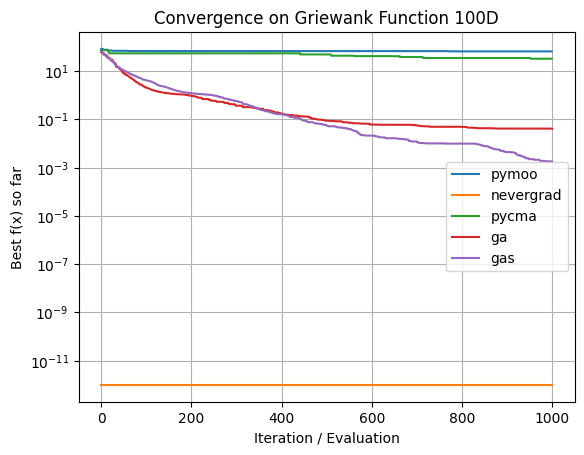

In [484]:
hist_g_ga = logger_griewangks_ga.data[0][1]
hist_g_gas = logger_griewangks_gas.data[0][1]

plot_convergence(
    [hist_g_pymoo, hist_g_ng, hist_g_cma, hist_g_ga, hist_g_gas],
    ["pymoo", "nevergrad", "pycma", "ga", "gas"],
    title="Convergence on Griewank Function 100D"
)

## Функция Швефеля

In [11]:
random.seed(241)
np.random.seed(241)

dimension_s = 100
function_s = schwefels_function
population_size = 200
bounds = (-100, 100)
budget = 1000

In [12]:
random.seed(241)
np.random.seed(241)

hist_s_pymoo, f_best_s_pymoo = run_pymoo_with_history(
    function_s, dimension_s, bounds, eval_budget=budget
)
print(f"pymoo:\nf_best = {f_best_s_pymoo}")

pymoo:
f_best = 35894.48555611569


In [13]:
random.seed(241)
np.random.seed(241)

hist_s_ng, f_best_s_ng = run_nevergrad_with_history(
    function_s, dimension_s, bounds, budget=budget
)
print(f"nevergrad:\nf_best = {f_best_s_ng}")

nevergrad:
f_best = 41503.76385490254


In [14]:
random.seed(241)
np.random.seed(241)

hist_s_cma, f_best_s_cma = run_pycma_with_history(
    function_s, dimension_s, bounds, eval_budget=budget
)
print(f"pycma:\nf_best = {f_best_s_cma}")

pycma:
f_best = 35765.45170313621


In [15]:
random.seed(241)
np.random.seed(241)
logger_schwefels_ga = DataLogger()

f_best_s_ga, x_best_s_ga = ga.run(population_size, dimension_s, budget, function_s,
                                  logger_schwefels_ga)

min fitness: 17760.18062420032
Execution time 8.149 sec.


In [487]:
random.seed(241)
np.random.seed(241)
logger_schwefels_gas = DataLogger()

f_best_s_gas, x_best_s_gas = gas_hdb_best_2.run(200, dimension_s, budget, function_s,
                                              logger_schwefels_gas)

min fitness: 17197.342898698993
Execution time 23.342 sec.


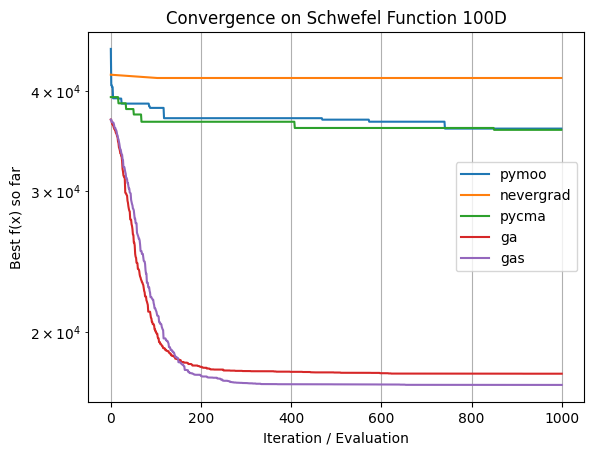

In [488]:
hist_s_ga = logger_schwefels_ga.data[0][1]
hist_s_gas = logger_schwefels_gas.data[0][1]

plot_convergence(
    [hist_s_pymoo, hist_s_ng, hist_s_cma, hist_s_ga, hist_s_gas],
    ["pymoo", "nevergrad", "pycma", "ga", "gas"],
    title="Convergence on Schwefel Function 100D"
)

## Функция CEC2014 (простая)

In [19]:
random.seed(241)
np.random.seed(241)

dimension_1 = 100
function_1 = get_f12014_function(dimension_1)
population_size = 200
bounds = (-100, 100)
budget = 1000

In [20]:
random.seed(241)
np.random.seed(241)

hist_1_pymoo, f_best_1_pymoo = run_pymoo_with_history(
    function_1, dimension_1, bounds, eval_budget=budget
)
print(f"pymoo:\nf_best = {f_best_1_pymoo}")

pymoo:
f_best = 15696700767.71279


In [21]:
random.seed(241)
np.random.seed(241)

hist_1_ng, f_best_1_ng = run_nevergrad_with_history(
    function_1, dimension_1, bounds, budget=budget
)
print(f"nevergrad:\nf_best = {f_best_1_ng}")

nevergrad:
f_best = 11096108878.79671


In [22]:
random.seed(241)
np.random.seed(241)

hist_1_cma, f_best_1_cma = run_pycma_with_history(
    function_1, dimension_1, bounds, eval_budget=budget
)
print(f"pycma:\nf_best = {f_best_1_cma}")

pycma:
f_best = 4750178036.5805855


In [23]:
random.seed(241)
np.random.seed(241)
logger_f12014_ga = DataLogger()

f_best_1_ga, x_best_1_ga = ga.run(population_size, dimension_1, budget, function_1,
                                  logger_f12014_ga)

min fitness: 73419250.43233524
Execution time 9.208 sec.


In [479]:
random.seed(241)
np.random.seed(241)
logger_f12014_gas = DataLogger()

f_best_1_gas, x_best_1_gas = gas_hdb_best.run(population_size, dimension_1, budget, function_1,
                                              logger_f12014_gas)

min fitness: 60810613.089744814
Execution time 27.185 sec.


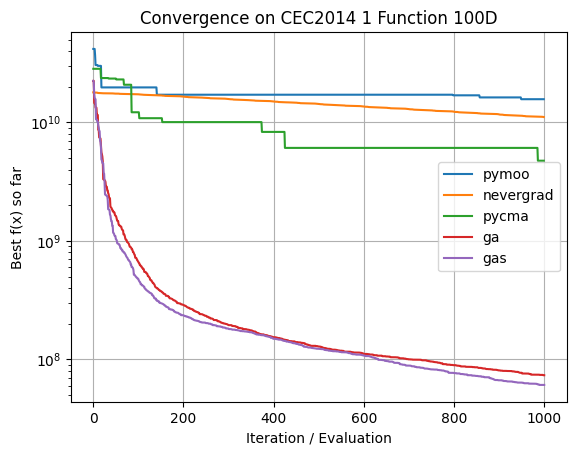

In [480]:
hist_1_ga = logger_f12014_ga.data[0][1]
hist_1_gas = logger_f12014_gas.data[0][1]

plot_convergence(
    [hist_1_pymoo, hist_1_ng, hist_1_cma, hist_1_ga, hist_1_gas],
    ["pymoo", "nevergrad", "pycma", "ga", "gas"],
    title="Convergence on CEC2014 1 Function 100D"
)

## Функция CEC2014 (средняя)

In [490]:
random.seed(241)
np.random.seed(241)

dimension_2 = 10
function_2 = get_f122014_function(dimension_2)
population_size = 200
bounds = (-100, 100)
budget = 100

In [491]:
random.seed(241)
np.random.seed(241)

hist_2_pymoo, f_best_2_pymoo = run_pymoo_with_history(
    function_2, dimension_2, bounds, eval_budget=budget
)
print(f"pymoo:\nf_best = {f_best_2_pymoo}")

pymoo:
f_best = 1202.9123965699691


In [492]:
random.seed(241)
np.random.seed(241)

hist_2_ng, f_best_2_ng = run_nevergrad_with_history(
    function_2, dimension_2, bounds, budget=budget
)
print(f"nevergrad:\nf_best = {f_best_2_ng}")

nevergrad:
f_best = 1201.9594666481594


In [493]:
random.seed(241)
np.random.seed(241)

hist_2_cma, f_best_2_cma = run_pycma_with_history(
    function_2, dimension_2, bounds, eval_budget=budget
)
print(f"pycma:\nf_best = {f_best_2_cma}")

pycma:
f_best = 1204.2191593540258


In [494]:
random.seed(241)
np.random.seed(241)
logger_f122014_ga = DataLogger()

f_best_2_ga, x_best_2_ga = ga.run(population_size, dimension_2, budget, function_2,
                                  logger_f122014_ga)

min fitness: 1200.1409106467108
Execution time 88.175 sec.


In [495]:
random.seed(241)
np.random.seed(241)
logger_f122014_gas = DataLogger()

f_best_2_gas, x_best_2_gas = gas_hdb_best.run(population_size, dimension_2, budget, function_2,
                                              logger_f122014_gas)

min fitness: 1200.1482362410625
Execution time 128.174 sec.


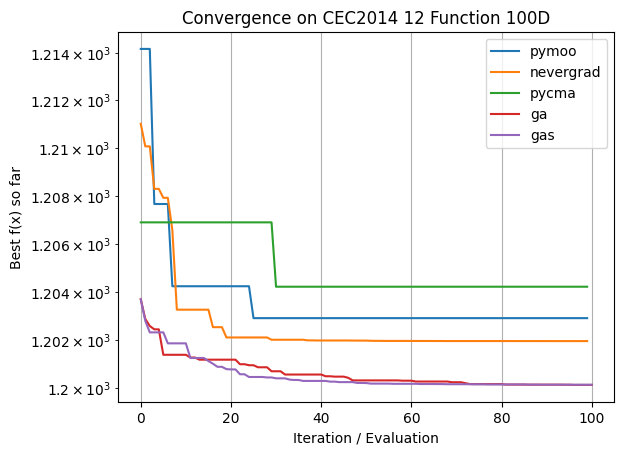

In [496]:
hist_2_ga = logger_f122014_ga.data[0][1]
hist_2_gas = logger_f122014_gas.data[0][1]

plot_convergence(
    [hist_2_pymoo, hist_2_ng, hist_2_cma, hist_2_ga, hist_2_gas],
    ["pymoo", "nevergrad", "pycma", "ga", "gas"],
    title="Convergence on CEC2014 12 Function 100D"
)

## Функция CEC2014 (сложная)

In [504]:
random.seed(241)
np.random.seed(241)

dimension_3 = 10
function_3 = get_f242014_function(dimension_3)
population_size = 200
bounds = (-100, 100)
budget = 1000

In [505]:
random.seed(241)
np.random.seed(241)

hist_3_pymoo, f_best_3_pymoo = run_pymoo_with_history(
    function_3, dimension_3, bounds, eval_budget=budget
)
print(f"pymoo:\nf_best = {f_best_3_pymoo}")

pymoo:
f_best = 2566.3245764833355


In [506]:
random.seed(241)
np.random.seed(241)

hist_3_ng, f_best_3_ng = run_nevergrad_with_history(
    function_3, dimension_3, bounds, budget=budget
)
print(f"nevergrad:\nf_best = {f_best_3_ng}")

nevergrad:
f_best = 2566.2397825775447


In [507]:
random.seed(241)
np.random.seed(241)

hist_3_cma, f_best_3_cma = run_pycma_with_history(
    function_3, dimension_3, bounds, eval_budget=budget
)
print(f"pycma:\nf_best = {f_best_3_cma}")

pycma:
f_best = 2524.1653951756166


In [508]:
random.seed(241)
np.random.seed(241)
logger_f242014_ga = DataLogger()

f_best_3_ga, x_best_3_ga = ga.run(population_size, dimension_3, budget, function_3,
                                  logger_f242014_ga)

min fitness: 2537.321490249659
Execution time 79.388 sec.


In [509]:
random.seed(241)
np.random.seed(241)
logger_f242014_gas = DataLogger()

f_best_3_gas, x_best_3_gas = gas_hdb_best.run(population_size, dimension_3, budget, function_3,
                                              logger_f242014_gas)

min fitness: 2526.0704078394015
Execution time 117.427 sec.


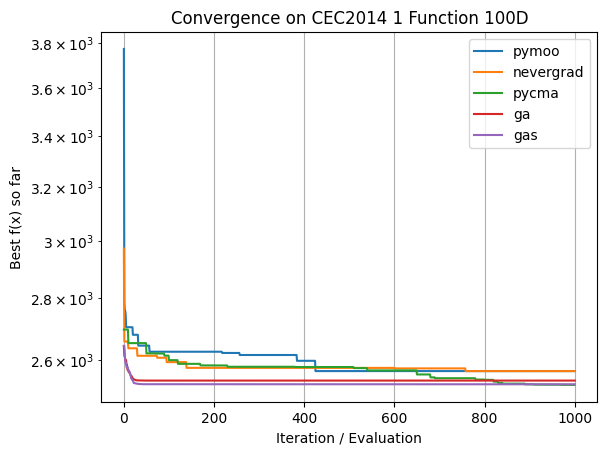

In [510]:
hist_3_ga = logger_f242014_ga.data[0][1]
hist_3_gas = logger_f242014_gas.data[0][1]

plot_convergence(
    [hist_3_pymoo, hist_3_ng, hist_3_cma, hist_3_ga, hist_3_gas],
    ["pymoo", "nevergrad", "pycma", "ga", "gas"],
    title="Convergence on CEC2014 1 Function 100D"
)